In [32]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scib
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# SVM Classifiers for RxRx19b, HUVEC

For more information on the dataset please see: https://www.rxrx.ai/rxrx19b and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx19b/rxrx19b_overview.md <br>

* [I. Read in processed data](#read)
* [II. Label key: disease condition](#dc)
    * [A. SVM before integration](#dc_sub1)
    * [B. SVM after integration with harmony](#dc_sub2)
    * [C. SVM after integration with scanorama](#dc_sub3)
    * [D. SVM after integration with scVI](#dc_sub4)
    * [E. SVM after integration with scANVI](#dc_sub5)
    * [F. SVM after integration with scGEN](#dc_sub6)
* [III. Label key: treatment](#treat)
    * [A. SVM before integration](#treat_sub1)
    * [B. SVM after integration with harmony](#treat_sub2)
    * [C. SVM after integration with scanorama](#treat_sub3)
    * [D. SVM after integration with scVI](#treat_sub4)
    * [E. SVM after integration with scANVI](#treat_sub5)
    * [F. SVM after integration with scGen](#treat_sub6)
* [IV. Investigate biology for misclassified instances](#bio)
    * [A. DrugBank search for misclassified instances](#bio_sub1) 
    * [B. DrugBank search for misclassified instances from SVM harmony](#bio_sub2) 
    * [C. DrugBank search for misclassified instances from SVM scanorama](#bio_sub3) 
    * [D. DrugBank search for misclassified instances from SVM scVI](#bio_sub4) 
    * [E. DrugBank search for misclassified instances from SVM scANVI](#bio_sub5) 
    * [F. DrugBank search for misclassified instances from SVM scGen](#bio_sub6) 

## I. Read in processed data  <a class="anchor" id="read"></a>

Load in both anndata objects: processed adata (before harmony integration) and harmony (after integration).

In [26]:
# Adata before integration
adata = sc.read("./rxrx19b_adata.h5ad")
adata.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0,0.076258
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0,0.132280
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,0.092923
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,0,0.074591
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,0,0.060353
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,-0.041384
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,0.124158
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,0.160160


In [27]:
# Harmony after integration
harmony = sc.read("./rxrx19b_harmony.h5ad")
harmony.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,silhouette_temp,cluster
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0.036751,0
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0.026141,0
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.010373,0
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,-0.029200,0
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,-0.024376,0
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,-0.050457,3
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0.120337,0
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0.167888,0


In [17]:
# Scanorama integration
scanorama = sc.read("./rxrx19b_scanorama.h5ad")
scanorama.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_1_AA02_1,HUVEC-1_1_AA02,HUVEC,HUVEC-1,1,AA02,1,storm-severe,Ravoxertinib,1.000,CN1N=CC=C1NC1=NC=CC(=N1)C1=CC(=O)N(C=C1)C(CO)C...,0,0.092706
HUVEC-1_1_AA03_1,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,storm-severe,Diphenylpyraline,0.250,"CN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1 |c:12,14...",0,0.158894
HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,storm-severe,Indirubin,1.000,O=C1NC2=CC=CC=C2\C1=C1\NC2=C(C=CC=C2)C1=O |c:5...,0,0.101708
HUVEC-1_1_AA05_1,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,1,storm-severe,YO-01027,1.000,C[C@H](NC(=O)CC1=CC(F)=CC(F)=C1)C(=O)N[C@H]1C2...,0,0.123514
HUVEC-1_1_AA07_1,HUVEC-1_1_AA07,HUVEC,HUVEC-1,1,AA07,1,storm-severe,taurine,1.000,NCCS(O)(=O)=O,0,0.107874
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,-0.099862
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,0.155186
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,0.196267


In [18]:
# scVI integration
scVI = sc.read("./rxrx19b_scVI.h5ad")
scVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0,-0.543727
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0,-0.621687
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,-0.628575
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,0,-0.529617
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,0,-0.535285
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,-0.196521
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,-0.512787
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,-0.510937


In [19]:
# scANVI integration
scANVI = sc.read("./rxrx19b_scANVI.h5ad")
scANVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,0,0.786475
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,0,0.754290
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,0.814158
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,0,0.816677
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,0,0.732051
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,3,0.048619
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,0,0.802998
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",0,0.776060


In [3]:
# scGen integration
scGen = sc.read("./rxrx19b_scGen.h5ad")
scGen.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,_scvi_batch,_scvi_labels,concat_batch,cluster,silhouette_temp
site_id,,,,,,,,,,,,,,,
HUVEC-1_10_AA02_1,HUVEC-1_10_AA02,HUVEC,HUVEC-1,10,AA02,1,storm-severe,NaN,0.000,NaN,9,2,0,1,-0.098082
HUVEC-1_10_AA03_1,HUVEC-1_10_AA03,HUVEC,HUVEC-1,10,AA03,1,storm-severe,NaN,0.000,NaN,9,2,0,0,0.054734
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,9,2,0,0,-0.028665
HUVEC-1_10_AA05_1,HUVEC-1_10_AA05,HUVEC,HUVEC-1,10,AA05,1,storm-severe,Nafronyl,1.000,CCN(CC)CCOC(=O)C(CC1CCCO1)CC1=CC=CC2=CC=CC=C12...,9,2,0,0,-0.028265
HUVEC-1_10_AA06_1,HUVEC-1_10_AA06,HUVEC,HUVEC-1,10,AA06,1,storm-severe,Zaltoprofen,0.100,CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1 |c...,9,2,0,0,-0.042708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,8,1,0,1,-0.057290
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,8,2,0,0,0.103738
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",8,2,0,0,0.110647


In [31]:
# Treatments before integration
treatment = sc.read("./rxrx19b_top_50_treatments.h5ad")
treatment.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,19,-0.064533
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,15,-0.040772
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,-0.101457
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,15,0.046645
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,0,-0.121994
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,19,-0.030097
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,7,-0.062839
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,19,-0.006083


In [7]:
# Treatments Harmony after integration
treatment_harmony = sc.read("./rxrx19b_top_50_treatments_harmony.h5ad")
treatment_harmony.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,silhouette_temp,cluster
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.079270,0
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.112874,11
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.193622,2
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.092716,11
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.197519,2
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.077464,15
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.104707,1
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,-0.059804,15


In [21]:
# Treatments after scanorama integration
treatment_scanorama = sc.read("./rxrx19b_top_50_treatments_scanorama.h5ad")
treatment_scanorama.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,4,-0.035203
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,10,-0.135421
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,17,-0.112351
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,10,0.013212
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.133789
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,8,-0.084234
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,-0.025475
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.083531


In [33]:
# Treatments after scVI integration
treatment_scVI = sc.read("./rxrx19b_top_50_treatments_scVI.h5ad")
treatment_scVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.516933
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,-0.110241
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,1,-0.503312
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,-0.249883
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.537056
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.501894
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,-0.528379
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.538724


In [34]:
# Treatments after scanVI integration
treatment_scANVI = sc.read("./rxrx19b_top_50_treatments_scANVI.h5ad")
treatment_scANVI.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp
site_id,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.280787
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,0.021866
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,1,-0.283447
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,12,0.008462
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,-0.442699
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.021719
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,-0.237868
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,18,-0.120097


In [35]:
# Treatments after scGen integration
treatment_scGen = sc.read("./rxrx19b_top_50_treatments_scGen.h5ad")
treatment_scGen.obs

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,_scvi_batch,_scvi_labels,cluster,silhouette_temp
site_id,,,,,,,,,,,,,,
HUVEC-1_10_AA04_1,HUVEC-1_10_AA04,HUVEC,HUVEC-1,10,AA04,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.103188
HUVEC-1_10_AE37_1,HUVEC-1_10_AE37,HUVEC,HUVEC-1,10,AE37,1,storm-severe,Pyrithione,1.000,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.080010
HUVEC-1_10_L11_1,HUVEC-1_10_L11,HUVEC,HUVEC-1,10,L11,1,storm-severe,Pyrithione,0.250,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.113245
HUVEC-1_10_Q07_1,HUVEC-1_10_Q07,HUVEC,HUVEC-1,10,Q07,1,storm-severe,Pyrithione,2.500,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.218554
HUVEC-1_10_S07_1,HUVEC-1_10_S07,HUVEC,HUVEC-1,10,S07,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,3,27,23,0.105714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-1_7_F13_1,HUVEC-1_7_F13,HUVEC,HUVEC-1,7,F13,1,storm-severe,Pyrithione,0.100,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,27,23,0.177709
HUVEC-1_7_P47_1,HUVEC-1_7_P47,HUVEC,HUVEC-1,7,P47,1,storm-severe,Pyrithione,0.010,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,27,3,-0.036196
HUVEC-1_7_W11_1,HUVEC-1_7_W11,HUVEC,HUVEC-1,7,W11,1,storm-severe,Pyrithione,0.025,[Zn++].[O-][N+]1=CC=CC=C1[S-].[O-][N+]1=CC=CC=...,2,27,23,0.118412


## II. Label key: disease condition  <a class="anchor" id="dc"></a>

<b>Goal:<b>
    
1. We want a classifier which can correctly classify instances into the categories "healthy" or "storm-severe" (different treatments in III.). We discard the "blank" case as this group clusters within the "healthy" cluster and is only included in plate 53. 

2. We want to check if after integration the classifiers performance improves or not.

<b> Why SVM? <b>

* SVM is generally robust to outliers due to the use of a margin.
* SVM can deal with complex, high-dimensional and non-linear data.
* SVM has hyperparameters which can be tuned to improve performance. Important hyperparameters include C (regularization parameter), gamma (kernel coefficient), and the choice of kernel (linear, polynomial, or radial basis function). A regularization coefficient C = 1.0 means that the SVM model is using a moderate level of regularization. A higher value of C (e.g., 10.0) indicates less regularization, while a lower value of C (e.g., 0.1) indicates stronger regularization.

However, SVMs can be sensitive to the choice of kernel function and its hyperparameters.

### A. SVM before integration  <a class="anchor" id="dc_sub1"></a>

<b> Step 1: <b>
    
Split adata into training and test sets and remove the "blank" condition before training.

In [9]:
# Make new adata_object (before integration)
adata_no_blank = adata.copy()

# Filter cells with "blank" disease condition
adata_no_blank = adata_no_blank[adata_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
adata_no_blank.obs["n_cells"] = adata_no_blank.X.sum(axis=1)

# Update the observation index
adata_no_blank.obs.index = range(adata_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
adata_no_blank.obs["disease_condition"] = adata_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
adata_no_blank = adata_no_blank[~adata_no_blank.obs["disease_condition"].isna()]

In [10]:
# Perform PCA on `adata` without batch correction or integration
sc.tl.pca(adata_no_blank, n_comps=50)  # Choose the desired number of components

# Split adata_no_blank into train and test
X_adata_no_blank = adata_no_blank.obsm["X_pca"]
y_adata_no_blank = adata_no_blank.obs['disease_condition']

X_train_adata, X_test_adata, y_train_adata, y_test_adata = train_test_split(X_adata_no_blank, y_adata_no_blank, test_size=0.2, random_state=42)

In [11]:
adata_no_blank.obsm["X_pca"]

array([[ 1.3651953e+00, -1.2343433e+00,  1.1859227e+00, ...,
        -2.3331618e-01, -1.8383896e-01, -3.3549076e-01],
       [-1.0056266e+00,  5.0491758e-02, -1.1128535e+00, ...,
         4.2527881e-01,  1.3812271e-01,  8.5469864e-02],
       [-4.8382667e-01, -1.8016112e+00, -2.9532328e-01, ...,
        -5.4519787e-02, -1.6023353e-01, -8.3027622e-03],
       ...,
       [-8.7735802e-02, -1.0194504e+00,  6.5616220e-01, ...,
         1.6858843e-01, -3.4408242e-01, -2.5574991e-01],
       [ 1.4133677e+00, -1.9894869e+00, -2.3276141e+00, ...,
         5.9777573e-03, -5.2248532e-01,  3.3537263e-01],
       [ 2.2478988e+00, -6.6597924e+00, -3.4944057e-01, ...,
         1.0794930e-01,  5.9323762e-02, -1.3666278e-01]], dtype=float32)

<b> Step 2: <b>
    
Train the SVM classifier.

In [12]:
# Training
svm_classifier_adata = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_adata.fit(X_train_adata, y_train_adata)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [13]:
# Testing for adata_no_blank
y_pred_adata = svm_classifier_adata.predict(X_test_adata)

# Predict probabilities for test data
probabilities = svm_classifier_adata.predict_proba(X_test_adata)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
       0.99122165])

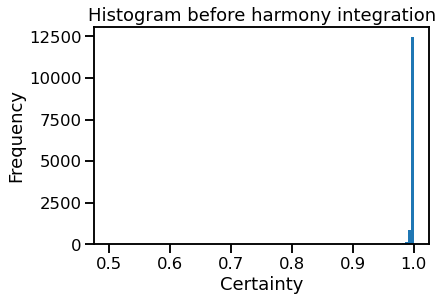

In [8]:
# Plot histogram
plt.hist(uncertainty_measures, bins=100) 
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram before integration')
plt.show()

We now only have two classes (binary classification!), "healthy" and "storm-severe", the uncertainty measures therefore represent the probability estimates for each prediction. 

The majority of the predictions have a certainty of (almost) 1, indicating that the classifier is very confident in its predictions for those samples. 

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [14]:
# Evaluating for adata_no_blank
accuracy_adata = accuracy_score(y_test_adata, y_pred_adata)
confusion_adata = confusion_matrix(y_test_adata, y_pred_adata)
classification_rep_adata = classification_report(y_test_adata, y_pred_adata)

# Calculate the true positives for each class
true_positives = np.diag(confusion_adata)

# Calculate the total instances for each class
total_instances = np.sum(confusion_adata, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_adata)
print("Confusion Matrix:")
print(confusion_adata)
print("Classification Report:")
print(classification_rep_adata)

Balanced Accuracy: 0.9776688037317074
Accuracy: 0.99343981745579
Confusion Matrix:
[[  512    21]
 [   71 13420]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.88      0.96      0.92       533
storm-severe       1.00      0.99      1.00     13491

    accuracy                           0.99     14024
   macro avg       0.94      0.98      0.96     14024
weighted avg       0.99      0.99      0.99     14024



<b> Interpretation: <b>

* The accuracy score indicates the proportion of correctly classified instances in your dataset. In this case, the SVM classifier achieved an accuracy of approximately 99.3%, which is quite high.
* The confusion matrix provides a breakdown of the predicted labels compared to the actual labels. It shows the number of instances classified correctly and incorrectly for each class. The matrix is organized as follows:
- True Negative (TN): 512
- False Positive (FP): 21
- False Negative (FN): 71
- True Positive (TP): 13420
* Precision: It measures the proportion of correctly predicted positive instances out of all instances predicted as positive. For the "healthy" class, the precision is 0.88, indicating that 88% of instances predicted as "healthy" were actually "healthy." For the "storm-severe" class, the precision is 1.0, indicating perfect precision.
* Recall: It measures the proportion of correctly predicted positive instances out of all actual positive instances. The "healthy" class has a recall of 0.96, indicating that 96% of actual "healthy" instances were correctly predicted. The "storm-severe" class has a recall of 0.99, indicating that 99% of actual "storm-severe" instances were correctly predicted.
* F1-score: It is the harmonic mean of precision and recall, providing a balance between the two metrics. The "healthy" class has an F1-score of 0.92, and the "storm-severe" class has an F1-score of 1.0.
* Support: It represents the number of instances for each class. The "healthy" class has a support of 533, and the "storm-severe" class has a support of 13,491.
* The macro average calculates the average performance metrics across all classes, giving equal weight to each class. In this case, the macro average precision, recall, and F1-score are 0.94, 0.98, and 0.96, respectively.
* The weighted average calculates the average performance metrics weighted by the support of each class. In this case, the weighted average precision, recall, and F1-score are 0.99, 0.99, and 0.99, respectively.

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [32]:
# Perform 5-fold cross-validation on adata_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
cv_scores_adata = cross_val_score(svm_classifier, X_train_adata, y_train_adata, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_adata)
print("Mean CV Score:", np.mean(cv_scores_adata))

Cross-Validation Scores: [0.99411765 0.99402799 0.99429539 0.99331491 0.99331491]
Mean CV Score: 0.9938141702888481


### B. SVM after integration with harmony  <a class="anchor" id="dc_sub2"></a>

<b> Step 1: <b>
    
Split adata and harmony into training and test sets and remove the "blank" condition before training.

In [15]:
# Make new harmony_object (after integration) and discarding the "blank" condition
harmony_no_blank = harmony.copy()

# Filter cells with "blank" disease condition
harmony_no_blank = harmony_no_blank[harmony_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
harmony_no_blank.obs["n_cells"] = harmony_no_blank.X.sum(axis=1)

# Update the observation index
harmony_no_blank.obs.index = range(harmony_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
harmony_no_blank.obs["disease_condition"] = harmony_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
harmony_no_blank = harmony_no_blank[~harmony_no_blank.obs["disease_condition"].isna()]

In [16]:
# Split harmony_no_blank into train and test
X_harmony_no_blank = harmony_no_blank.obsm['X_emb']
y_harmony_no_blank = harmony_no_blank.obs['disease_condition']

X_train_harmony, X_test_harmony, y_train_harmony, y_test_harmony = train_test_split(X_harmony_no_blank, y_harmony_no_blank, test_size=0.2, random_state=42)

In [17]:
harmony_no_blank.obsm['X_emb']

ArrayView([[ 2.2394414 , -1.7375597 ,  2.7960627 , ..., -0.37198633,
            -0.1691206 , -0.38475117],
           [ 1.9186702 , -0.9331736 ,  0.5725336 , ...,  0.33663914,
             0.2135294 , -0.05475631],
           [ 2.4493425 , -2.7479894 ,  1.3818922 , ..., -0.14319813,
            -0.08162183, -0.14025837],
           ...,
           [-1.2527202 ,  0.44256347,  0.68235373, ...,  0.1390561 ,
            -0.32132152, -0.29450902],
           [ 1.0184435 , -0.5603703 , -2.6472228 , ..., -0.14857054,
            -0.30067638,  0.3474751 ],
           [ 0.7579213 , -4.075646  ,  0.08878634, ...,  0.05327755,
             0.18642084, -0.0782557 ]], dtype=float32)

<b> Step 2: <b>
    
Train the SVM classifier.

In [18]:
# Training
svm_classifier_harmony = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_harmony.fit(X_train_harmony, y_train_harmony)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [19]:
# Testing for harmony_no_blank
y_pred_harmony = svm_classifier_harmony.predict(X_test_harmony)

# Predict probabilities for test data
probabilities = svm_classifier_harmony.predict_proba(X_test_harmony)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([1.        , 1.        , 0.99999909, ..., 0.99999999, 1.        ,
       0.9959814 ])

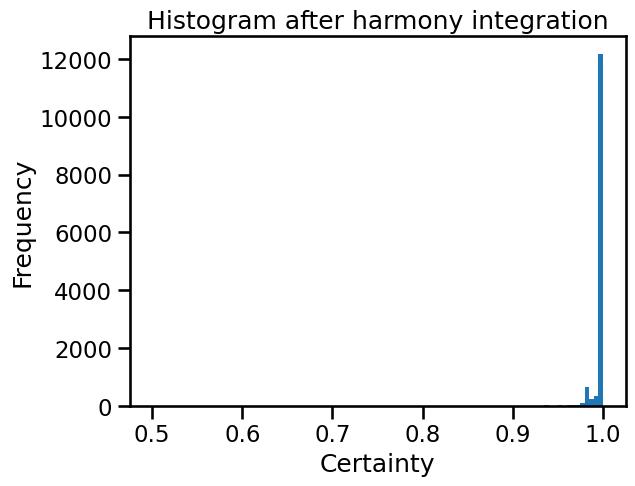

In [62]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after harmony integration')
plt.show()

We again see that the SVM has a very high certainty in general but uncertainty does increase a little bit after integration with harmony compared to the unintegrated uncertainty.

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [20]:
# Evaluating for harmony_no_blank
accuracy_harmony = accuracy_score(y_test_harmony, y_pred_harmony)
confusion_harmony = confusion_matrix(y_test_harmony, y_pred_harmony)
classification_rep_harmony = classification_report(y_test_harmony, y_pred_harmony)

# Calculate the true positives for each class
true_positives = np.diag(confusion_harmony)

# Calculate the total instances for each class
total_instances = np.sum(confusion_harmony, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_harmony)
print("Confusion Matrix:")
print(confusion_harmony)
print("Classification Report:")
print(classification_rep_harmony)

Balanced Accuracy: 0.9705462734311234
Accuracy: 0.9918710781517399
Confusion Matrix:
[[  505    28]
 [   86 13405]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.85      0.95      0.90       533
storm-severe       1.00      0.99      1.00     13491

    accuracy                           0.99     14024
   macro avg       0.93      0.97      0.95     14024
weighted avg       0.99      0.99      0.99     14024



Overall, the SVM classifier performs very well with high accuracy and good precision, recall, and F1-score for both classes before as well as after integration. It shows a high ability to distinguish between the "healthy" and "storm-severe" classes. The accuracy decreases after integration slightly though which may indicate that harmony compromises the biology a little bit while correcting for plate effect.
    
In general though, we see that the SVM classifier's performance remains more or less the same before and after applying harmony integration, meaning the batch correction method apparently did not have a significant impact on the classifier's ability to distinguish between different classes. 
    
-> Perhaps this is because we had very minimal batch effect (plate effect) to begin with and harmony did not have much to correct.
    
-> We know that harmony primarily deals with linear batch effects. The batch effect in this dataset may be non-linear though and thus harmony or even the SVM classifier may not have been an ideal choice which is why it maybe worth to look into other integration methods or train different classifiers.

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [33]:
# Perform 5-fold cross-validation on harmony_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
cv_scores_harmony = cross_val_score(svm_classifier, X_train_harmony, y_train_harmony, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_harmony)
print("Mean CV Score:", np.mean(cv_scores_harmony))

Cross-Validation Scores: [0.99349376 0.99376058 0.99393885 0.99144309 0.99215616]
Mean CV Score: 0.9929584901727224


We can again see that the resulting values are almost identical before and after integration with harmony. The slight difference in the scores could be due to the random variability introduced by the different splits or due to some loss of biological conservation after integration with harmony.

### C. SVM after integration with scanorama  <a class="anchor" id="dc_sub3"></a>

<b> Step 1: <b>
    
Split adata and scanorama into training and test sets and remove the "blank" condition before training.

In [21]:
# Make new harmony_object (after integration) and discarding the "blank" condition
scanorama_no_blank = scanorama.copy()

# Filter cells with "blank" disease condition
scanorama_no_blank = scanorama_no_blank[scanorama_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scanorama_no_blank.obs["n_cells"] = scanorama_no_blank.X.sum(axis=1)

# Update the observation index
scanorama_no_blank.obs.index = range(scanorama_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scanorama_no_blank.obs["disease_condition"] = scanorama_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scanorama_no_blank = scanorama_no_blank[~scanorama_no_blank.obs["disease_condition"].isna()]

In [22]:
# Split harmony_no_blank into train and test
X_scanorama_no_blank = scanorama_no_blank.obsm['X_pca']
y_scanorama_no_blank = scanorama_no_blank.obs['disease_condition']

X_train_scanorama, X_test_scanorama, y_train_scanorama, y_test_scanorama = train_test_split(X_scanorama_no_blank, y_scanorama_no_blank, test_size=0.2, random_state=42)

In [23]:
scanorama_no_blank.obsm['X_pca']

ArrayView([[ 1.2353509e-01, -7.7390738e-02, -1.4122464e-01, ...,
            -4.0428014e-04,  5.4067313e-03,  1.8780761e-03],
           [ 1.1586933e-02, -1.0235124e-01, -2.8946104e-02, ...,
             1.4191536e-03,  6.7304946e-03, -2.7869262e-03],
           [ 4.2632390e-02, -2.1727178e-02,  4.9627670e-03, ...,
            -1.4822840e-04, -6.9791760e-04, -7.2839349e-03],
           ...,
           [ 1.3428365e-02, -8.1897050e-02, -8.0173306e-02, ...,
             1.8805164e-03, -1.1099721e-03,  2.9408853e-03],
           [ 2.0023329e-02, -4.5216024e-02,  1.7057396e-02, ...,
             7.4118224e-04, -5.8279424e-03, -1.3286283e-02],
           [ 8.3542310e-02, -2.6518008e-01,  1.6952690e-01, ...,
             5.8251382e-03, -5.0265361e-03,  8.1523033e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the SVM classifier.

In [24]:
# Training
svm_classifier_scanorama = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_scanorama.fit(X_train_scanorama, y_train_scanorama)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [25]:
# Testing for harmony_no_blank
y_pred_scanorama = svm_classifier_scanorama.predict(X_test_scanorama)

# Predict probabilities for test data
probabilities = svm_classifier_scanorama.predict_proba(X_test_scanorama)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([1., 1., 1., ..., 1., 1., 1.])

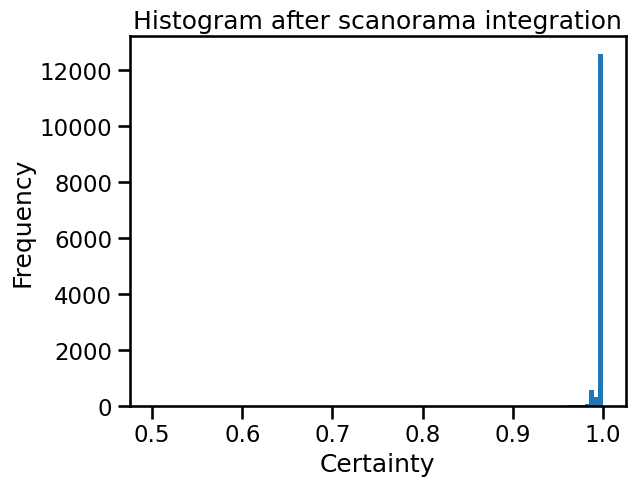

In [47]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scanorama integration')
plt.show()

No big change compared to certainty of unintegrated.

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [26]:
# Evaluating for scanorama_no_blank
accuracy_scanorama = accuracy_score(y_test_scanorama, y_pred_scanorama)
confusion_scanorama = confusion_matrix(y_test_scanorama, y_pred_scanorama)
classification_rep_scanorama = classification_report(y_test_scanorama, y_pred_scanorama)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scanorama)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scanorama, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scanorama)
print("Confusion Matrix:")
print(confusion_scanorama)
print("Classification Report:")
print(classification_rep_scanorama)

Balanced Accuracy: 0.982530259039115
Accuracy: 0.9940815744438106
Confusion Matrix:
[[  549    17]
 [   66 13392]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.89      0.97      0.93       566
storm-severe       1.00      1.00      1.00     13458

    accuracy                           0.99     14024
   macro avg       0.95      0.98      0.96     14024
weighted avg       0.99      0.99      0.99     14024



Overall, the SVM classifier performs very well with high accuracy and good precision, recall, and F1-score for both classes before as well as after integration. It shows a high ability to distinguish between the "healthy" and "storm-severe" classes. The accuracy increases after integration slightly.
    
This may be due to the fact that we already know that scanorama scales well for complex, high-dimensional data, better than harmony for instance.

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [49]:
# Perform 5-fold cross-validation on scanorama_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
cv_scores_scanorama = cross_val_score(svm_classifier, X_train_scanorama, y_train_scanorama, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scanorama)
print("Mean CV Score:", np.mean(cv_scores_scanorama))

Cross-Validation Scores: [0.99491979 0.99242357 0.99376058 0.99322578 0.99313664]
Mean CV Score: 0.993493271774916


We again see that the accuracy is improved compared to the SVM trained on unintegrated data.

### D. SVM after integration with scVI  <a class="anchor" id="dc_sub4"></a>

<b> Step 1: <b>
    
Split into training and test sets and remove the "blank" condition before training.

In [3]:
# Make new scVI_object (after integration) and discarding the "blank" condition
scVI_no_blank = scVI.copy()

# Filter cells with "blank" disease condition
scVI_no_blank = scVI_no_blank[scVI_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scVI_no_blank.obs["n_cells"] = scVI_no_blank.X.sum(axis=1)

# Update the observation index
scVI_no_blank.obs.index = range(scVI_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scVI_no_blank.obs["disease_condition"] = scVI_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scVI_no_blank = scVI_no_blank[~scVI_no_blank.obs["disease_condition"].isna()]

In [4]:
# Split harmony_no_blank into train and test
X_scVI_no_blank = scVI_no_blank.obsm['X_pca']
y_scVI_no_blank = scVI_no_blank.obs['disease_condition']

X_train_scVI, X_test_scVI, y_train_scVI, y_test_scVI = train_test_split(X_scVI_no_blank, y_scVI_no_blank, test_size=0.2, random_state=42)

In [5]:
scVI_no_blank.obsm['X_pca']

ArrayView([[ 1.52219772e-01, -1.10791340e-01,  1.48034543e-01, ...,
            -5.75463194e-03,  9.31165088e-03, -1.52409645e-02],
           [-1.10116303e-01, -3.66436550e-03, -1.18934117e-01, ...,
             4.35873959e-03,  1.19227776e-02, -1.37304766e-02],
           [-4.42312956e-02, -1.94126233e-01,  3.56000848e-02, ...,
            -1.40653308e-02,  1.39386114e-02, -1.22656906e-02],
           ...,
           [ 1.45090185e-02, -9.42047164e-02,  1.74487650e-01, ...,
             9.74718761e-03,  2.77364370e-03,  1.55082978e-02],
           [ 1.27000481e-01, -2.09646255e-01, -1.87120125e-01, ...,
            -1.28766929e-04, -1.38223004e-02,  2.09101588e-02],
           [ 2.30612487e-01, -6.86844409e-01, -3.73101197e-02, ...,
             1.70994718e-02,  6.86851563e-04,  4.19308059e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the SVM classifier.

In [6]:
# Training
svm_classifier_scVI = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_scVI.fit(X_train_scVI, y_train_scVI)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [7]:
# Testing for harmony_no_blank
y_pred_scVI = svm_classifier_scVI.predict(X_test_scVI)

# Predict probabilities for test data
probabilities = svm_classifier_scVI.predict_proba(X_test_scVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
       0.99322634])

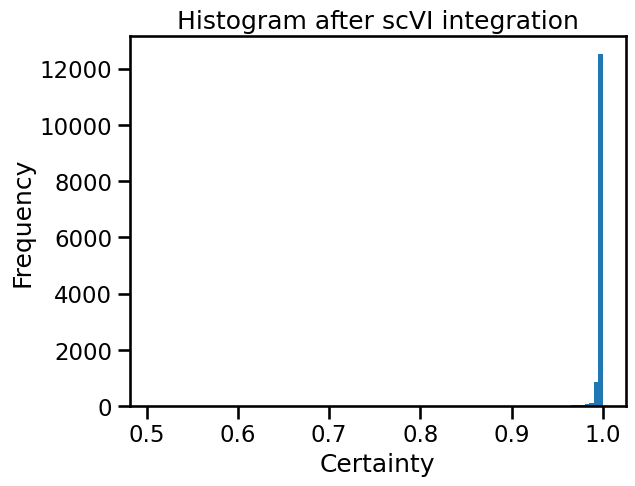

In [8]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scVI integration')
plt.show()

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [9]:
# Evaluating for scanorama_no_blank
accuracy_scVI = accuracy_score(y_test_scVI, y_pred_scVI)
confusion_scVI = confusion_matrix(y_test_scVI, y_pred_scVI)
classification_rep_scVI = classification_report(y_test_scVI, y_pred_scVI)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scVI)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scVI, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scVI)
print("Confusion Matrix:")
print(confusion_scVI)
print("Classification Report:")
print(classification_rep_scVI)

Balanced Accuracy: 0.9797302850639221
Accuracy: 0.993938961779806
Confusion Matrix:
[[  514    19]
 [   66 13425]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.89      0.96      0.92       533
storm-severe       1.00      1.00      1.00     13491

    accuracy                           0.99     14024
   macro avg       0.94      0.98      0.96     14024
weighted avg       0.99      0.99      0.99     14024



Overall, the SVM classifier performs very well with high accuracy and good precision, recall, and F1-score for both classes before as well as after integration. It shows a high ability to distinguish between the "healthy" and "storm-severe" classes. The accuracy increases after integration slightly.
    
This may be due to the fact that we already know that scvi scales well for complex, high-dimensional data, better than harmony for instance.

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [11]:
# Perform 5-fold cross-validation on scanorama_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
cv_scores_scVI = cross_val_score(svm_classifier, X_train_scVI, y_train_scVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scVI)
print("Mean CV Score:", np.mean(cv_scores_scVI))

Cross-Validation Scores: [0.99411765 0.99474106 0.9945628  0.99384972 0.99376058]
Mean CV Score: 0.9942063621063009


We again see that the accuracy is improved compared to the SVM trained on unintegrated data.

### E. SVM after integration with scANVI  <a class="anchor" id="dc_sub5"></a>

<b> Step 1: <b>
    
Split into training and test sets and remove the "blank" condition before training.

In [17]:
# Make new scVI_object (after integration) and discarding the "blank" condition
scANVI_no_blank = scANVI.copy()

# Filter cells with "blank" disease condition
scANVI_no_blank = scANVI_no_blank[scANVI_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scANVI_no_blank.obs["n_cells"] = scANVI_no_blank.X.sum(axis=1)

# Update the observation index
scANVI_no_blank.obs.index = range(scANVI_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scANVI_no_blank.obs["disease_condition"] = scANVI_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scANVI_no_blank = scANVI_no_blank[~scANVI_no_blank.obs["disease_condition"].isna()]

In [18]:
# Split scANVI_no_blank into train and test
X_scANVI_no_blank = scANVI_no_blank.obsm['X_pca']
y_scANVI_no_blank = scANVI_no_blank.obs['disease_condition']

X_train_scANVI, X_test_scANVI, y_train_scANVI, y_test_scANVI = train_test_split(X_scANVI_no_blank, y_scANVI_no_blank, test_size=0.2, random_state=42)

In [19]:
scANVI_no_blank.obsm['X_pca']

ArrayView([[ 1.52219772e-01, -1.10791340e-01,  1.48034543e-01, ...,
            -5.75463194e-03,  9.31165088e-03, -1.52409645e-02],
           [-1.10116303e-01, -3.66436550e-03, -1.18934117e-01, ...,
             4.35873959e-03,  1.19227776e-02, -1.37304766e-02],
           [-4.42312956e-02, -1.94126233e-01,  3.56000848e-02, ...,
            -1.40653308e-02,  1.39386114e-02, -1.22656906e-02],
           ...,
           [ 1.45090185e-02, -9.42047164e-02,  1.74487650e-01, ...,
             9.74718761e-03,  2.77364370e-03,  1.55082978e-02],
           [ 1.27000481e-01, -2.09646255e-01, -1.87120125e-01, ...,
            -1.28766929e-04, -1.38223004e-02,  2.09101588e-02],
           [ 2.30612487e-01, -6.86844409e-01, -3.73101197e-02, ...,
             1.70994718e-02,  6.86851563e-04,  4.19308059e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the SVM classifier.

In [20]:
# Training
svm_classifier_scANVI = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_scANVI.fit(X_train_scANVI, y_train_scANVI)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [21]:
# Testing for harmony_no_blank
y_pred_scANVI = svm_classifier_scANVI.predict(X_test_scANVI)

# Predict probabilities for test data
probabilities = svm_classifier_scANVI.predict_proba(X_test_scANVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
       0.99308182])

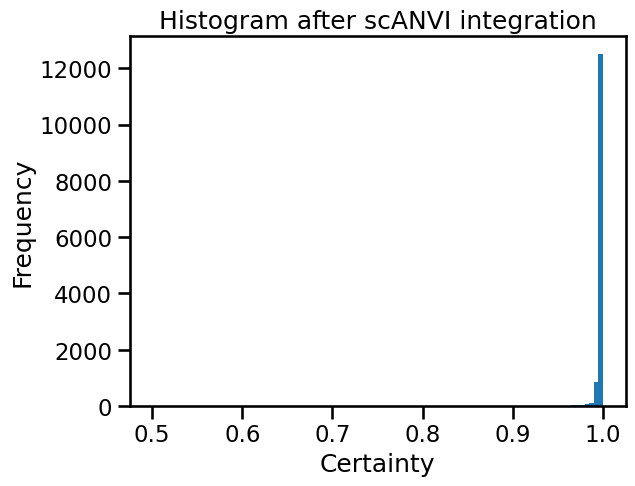

In [22]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scANVI integration')
plt.show()

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [23]:
# Evaluating for scanorama_no_blank
accuracy_scANVI = accuracy_score(y_test_scANVI, y_pred_scANVI)
confusion_scANVI = confusion_matrix(y_test_scANVI, y_pred_scANVI)
classification_rep_scANVI = classification_report(y_test_scANVI, y_pred_scANVI)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scANVI)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scANVI, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scANVI)
print("Confusion Matrix:")
print(confusion_scANVI)
print("Classification Report:")
print(classification_rep_scANVI)

Balanced Accuracy: 0.9797302850639221
Accuracy: 0.993938961779806
Confusion Matrix:
[[  514    19]
 [   66 13425]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.89      0.96      0.92       533
storm-severe       1.00      1.00      1.00     13491

    accuracy                           0.99     14024
   macro avg       0.94      0.98      0.96     14024
weighted avg       0.99      0.99      0.99     14024



Overall, the SVM classifier performs very well with high accuracy and good precision, recall, and F1-score for both classes before as well as after integration. It shows a high ability to distinguish between the "healthy" and "storm-severe" classes. The accuracy increases after integration slightly.
    
This may be due to the fact that we already know that scvi scales well for complex, high-dimensional data, better than harmony for instance.

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [24]:
# Perform 5-fold cross-validation on scanorama_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
cv_scores_scANVI = cross_val_score(svm_classifier, X_train_scANVI, y_train_scANVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scANVI)
print("Mean CV Score:", np.mean(cv_scores_scANVI))

Cross-Validation Scores: [0.99411765 0.99474106 0.9945628  0.99384972 0.99376058]
Mean CV Score: 0.9942063621063009


We again see that the accuracy is improved compared to the SVM trained on unintegrated data.

### F. SVM after integration with scGen  <a class="anchor" id="dc_sub6"></a>

<b> Step 1: <b>
    
Split into training and test sets and remove the "blank" condition before training.

In [4]:
# Make new scVI_object (after integration) and discarding the "blank" condition
scGen_no_blank = scGen.copy()

# Filter cells with "blank" disease condition
scGen_no_blank = scGen_no_blank[scGen_no_blank.obs["disease_condition"] != "blank"]

# Update the cell count information
scGen_no_blank.obs["n_cells"] = scGen_no_blank.X.sum(axis=1)

# Update the observation index
scGen_no_blank.obs.index = range(scGen_no_blank.obs.shape[0])

# Remove unused categories in disease_condition column
scGen_no_blank.obs["disease_condition"] = scGen_no_blank.obs["disease_condition"].cat.remove_unused_categories()

# Remove any unassigned labels
scGen_no_blank = scGen_no_blank[~scGen_no_blank.obs["disease_condition"].isna()]

In [5]:
# Split scANVI_no_blank into train and test
X_scGen_no_blank = scGen_no_blank.obsm['X_pca']
y_scGen_no_blank = scGen_no_blank.obs['disease_condition']

X_train_scGen, X_test_scGen, y_train_scGen, y_test_scGen = train_test_split(X_scGen_no_blank, y_scGen_no_blank, test_size=0.2, random_state=42)

In [6]:
scGen_no_blank.obsm['X_pca']

ArrayView([[ 9.4209337e+00,  6.5944300e+00, -4.1686459e+00, ...,
            -1.0398821e-02, -3.6418967e-02,  3.9320789e-02],
           [-4.7500008e-01,  9.4499987e-01,  1.0347963e-02, ...,
             1.3036295e-02, -5.7940912e-03, -5.8357669e-03],
           [ 6.4262967e+00,  3.5531828e+00, -7.0174760e-01, ...,
             1.9936839e-03, -2.1574553e-02,  3.2452680e-02],
           ...,
           [-2.0526502e+00, -1.1657120e+00, -9.5946538e-01, ...,
             6.2084035e-03,  5.9978897e-03, -1.3664067e-02],
           [ 1.7728070e+00,  1.0652121e+00,  2.9518774e+00, ...,
             2.1686614e-03,  2.1896819e-02, -9.8496452e-02],
           [ 1.7333444e+00,  5.2857838e+00, -1.6957250e-01, ...,
             6.0689885e-02,  5.7007880e-03,  3.2291382e-03]],
          dtype=float32)

<b> Step 2: <b>
    
Train the SVM classifier.

In [7]:
# Training
svm_classifier_scGen = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_scGen.fit(X_train_scGen, y_train_scGen)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [8]:
# Testing for harmony_no_blank
y_pred_scGen = svm_classifier_scGen.predict(X_test_scGen)

# Predict probabilities for test data
probabilities = svm_classifier_scGen.predict_proba(X_test_scGen)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([1.        , 0.99999995, 1.        , ..., 1.        , 1.        ,
       0.95812298])

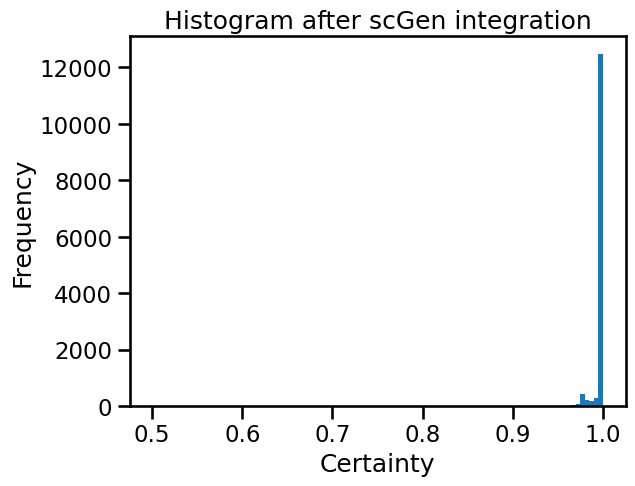

In [9]:
plt.hist(uncertainty_measures, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Certainty')
plt.ylabel('Frequency')
plt.title('Histogram after scGen integration')
plt.show()

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [10]:
# Evaluating for scanorama_no_blank
accuracy_scGen = accuracy_score(y_test_scGen, y_pred_scGen)
confusion_scGen = confusion_matrix(y_test_scGen, y_pred_scGen)
classification_rep_scGen = classification_report(y_test_scGen, y_pred_scGen)

# Calculate the true positives for each class
true_positives = np.diag(confusion_scGen)

# Calculate the total instances for each class
total_instances = np.sum(confusion_scGen, axis=1)

# Calculate the sensitivity (recall) for each class
sensitivity = true_positives / total_instances

# Calculate the balanced accuracy
balanced_accuracy = np.mean(sensitivity)

# Print results
print("Balanced Accuracy:", balanced_accuracy)
print("Accuracy:", accuracy_scGen)
print("Confusion Matrix:")
print(confusion_scGen)
print("Classification Report:")
print(classification_rep_scGen)

Balanced Accuracy: 0.966103731443226
Accuracy: 0.9937250427837993
Confusion Matrix:
[[  499    34]
 [   54 13437]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.90      0.94      0.92       533
storm-severe       1.00      1.00      1.00     13491

    accuracy                           0.99     14024
   macro avg       0.95      0.97      0.96     14024
weighted avg       0.99      0.99      0.99     14024



Overall, the SVM classifier performs very well with high accuracy and good precision, recall, and F1-score for both classes before as well as after integration. It shows a high ability to distinguish between the "healthy" and "storm-severe" classes. 

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [11]:
# Perform 5-fold cross-validation on scanorama_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
cv_scores_scGen = cross_val_score(svm_classifier, X_train_scGen, y_train_scGen, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_scGen)
print("Mean CV Score:", np.mean(cv_scores_scGen))

Cross-Validation Scores: [0.99420677 0.99349318 0.99331491 0.99304751 0.99278011]
Mean CV Score: 0.9933684961801653


We again see that the accuracy is improved compared to the SVM trained on unintegrated data.

## III. Label key: treatment  <a class="anchor" id="treat"></a>

### A. SVM before integration  <a class="anchor" id="treat_sub1"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [36]:
# Perform PCA on `adata` without batch correction or integration
sc.tl.pca(treatment, n_comps=50)  # Choose the desired number of components

# Split adata_no_blank into train and test
X_treatment = treatment.obsm["X_pca"]
y_treatment = treatment.obs['treatment']

X_train_treatment, X_test_treatment, y_train_treatment, y_test_treatment = train_test_split(X_treatment, y_treatment, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the SVM classifier.

In [37]:
# Training
svm_classifier_treatment = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_treatment.fit(X_train_treatment, y_train_treatment)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [45]:
# Testing for adata_no_blank
y_pred_treatment = svm_classifier_treatment.predict(X_test_treatment)

# Predict probabilities for test data
probabilities = svm_classifier_treatment.predict_proba(X_test_treatment)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.46831499, 0.0431915 , 0.04653901, 0.03567715, 0.03774876,
       0.03873756, 0.06645933, 0.0399481 , 0.04949631, 0.03570319,
       0.04142682, 0.0452066 , 0.05398938, 0.03323122, 0.23473904,
       0.03228636, 0.03085092, 0.03689916, 0.51976052, 0.03705139,
       0.05013141, 0.17750594, 0.0343778 , 0.0613343 , 0.03505523,
       0.09581916, 0.03895897, 0.0327609 , 0.0403143 , 0.06115777,
       0.06457202, 0.05352315, 0.05247502, 0.04013695, 0.05462858,
       0.06194955, 0.05944383, 0.0351444 , 0.04533463, 0.05380985,
       0.05226505, 0.03613529, 0.04816273, 0.03674668, 0.03678826,
       0.14225937, 0.05655987, 0.0365307 , 0.0391956 , 0.03662672,
       0.05632917, 0.32155828, 0.05961618, 0.03850887, 0.06710238,
       0.04058203, 0.04841528, 0.04293111, 0.03736564, 0.04290951,
       0.06014093, 0.05482511, 0.59217915, 0.05477244, 0.05775108,
       0.0501533 , 0.04282316, 0.03838578, 0.06412617, 0.03539757,
       0.06975719, 0.03340872, 0.04136466, 0.03500525, 0.05124

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [40]:
# Evaluating for adata_no_blank
accuracy_treatment = accuracy_score(y_test_treatment, y_pred_treatment)
print("Accuracy:", accuracy_treatment)

Accuracy: 0.10869565217391304


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [41]:
# Perform 5-fold cross-validation on adata_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
cv_scores_treatment = cross_val_score(svm_classifier, X_train_treatment, y_train_treatment, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment)
print("Mean CV Score:", np.mean(cv_scores_treatment))

Cross-Validation Scores: [0.13265306 0.13945578 0.1462585  0.16040956 0.10921502]
Mean CV Score: 0.137598384063523


### B. SVM after integration with harmony  <a class="anchor" id="treat_sub2"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [46]:
# Split into train and test
X_treatment_harmony = treatment_harmony.obsm['X_emb']
y_treatment_harmony = treatment_harmony.obs['treatment']

X_train_treatment_harmony, X_test_treatment_harmony, y_train_treatment_harmony, y_test_treatment_harmony = train_test_split(X_treatment_harmony, y_treatment_harmony, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the SVM classifier.

In [47]:
# Training
svm_classifier_treatment_harmony = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_treatment_harmony.fit(X_train_treatment_harmony, y_train_treatment_harmony)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [48]:
# Testing for adata_no_blank
y_pred_treatment_harmony = svm_classifier_treatment_harmony.predict(X_test_treatment_harmony)

# Predict probabilities for test data
probabilities = svm_classifier_treatment.predict_proba(X_test_treatment_harmony)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.74075644, 0.03848422, 0.0522648 , 0.03768443, 0.03714128,
       0.04019567, 0.07050014, 0.04169834, 0.04792643, 0.03308994,
       0.03832689, 0.03030726, 0.05770681, 0.03004776, 0.20287227,
       0.02961237, 0.03705864, 0.03483292, 0.71238503, 0.04312402,
       0.04420295, 0.15448752, 0.03733655, 0.06794683, 0.03382648,
       0.06022651, 0.03826961, 0.03336042, 0.03765057, 0.0477034 ,
       0.08147995, 0.05823714, 0.04769659, 0.04131709, 0.05361406,
       0.05343814, 0.0586825 , 0.04557936, 0.03525014, 0.06198347,
       0.0505368 , 0.03977355, 0.03517881, 0.035535  , 0.0303049 ,
       0.09512441, 0.05511846, 0.0367818 , 0.05695429, 0.04472185,
       0.05814017, 0.41863301, 0.04265353, 0.03155868, 0.05312277,
       0.04071516, 0.04440947, 0.04716991, 0.05691774, 0.03650149,
       0.05164702, 0.0439835 , 0.75945945, 0.05010055, 0.05364344,
       0.04666586, 0.05368267, 0.030882  , 0.06806671, 0.04112362,
       0.0656769 , 0.0387371 , 0.03548737, 0.03866151, 0.04175

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [49]:
# Evaluating for adata_no_blank
accuracy_treatment_harmony = accuracy_score(y_test_treatment_harmony, y_pred_treatment_harmony)
print("Accuracy:", accuracy_treatment_harmony)

Accuracy: 0.10054347826086957


Overall, the SVM classifier does not perform well regarding accuracy at all. In fact, the accuracy drops after integration. This could possibly indicate that some of the clustering of different treatments is also reduced a little bit after harmony. 

However, since we have known from the start that we do not neccessarily expect the treatments to form seperate clusters, this result is not entirely unexpected. 

<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [50]:
# Perform 5-fold cross-validation on adata_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
cv_scores_treatment_harmony = cross_val_score(svm_classifier, X_train_treatment_harmony, y_train_treatment_harmony, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_harmony)
print("Mean CV Score:", np.mean(cv_scores_treatment_harmony))

Cross-Validation Scores: [0.1292517  0.12585034 0.13945578 0.16040956 0.12969283]
Mean CV Score: 0.13693204244154997


We can again see that the score drops after integration.

### C. SVM after integration with scanorama  <a class="anchor" id="treat_sub3"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [26]:
# Split into train and test
X_treatment_scanorama = treatment_scanorama.obsm['X_emb']
y_treatment_scanorama = treatment_scanorama.obs['treatment']

X_train_treatment_scanorama, X_test_treatment_scanorama, y_train_treatment_scanorama, y_test_treatment_scanorama = train_test_split(X_treatment_scanorama, y_treatment_scanorama, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the SVM classifier.

In [27]:
# Training
svm_classifier_treatment_scanorama = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_treatment_scanorama.fit(X_train_treatment_scanorama, y_train_treatment_scanorama)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [29]:
# Testing for adata_no_blank
y_pred_treatment_scanorama = svm_classifier_treatment_scanorama.predict(X_test_treatment_scanorama)

# Predict probabilities for test data
probabilities = svm_classifier_treatment_scanorama.predict_proba(X_test_treatment_scanorama)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.4175528 , 0.04334397, 0.04556357, 0.04996517, 0.04524842,
       0.05183276, 0.04964022, 0.04340163, 0.04362073, 0.04042362,
       0.04525297, 0.04620065, 0.04020349, 0.04966344, 0.35142048,
       0.04659822, 0.04711254, 0.04317279, 0.65994274, 0.04207613,
       0.03929613, 0.24242214, 0.04044844, 0.04163495, 0.04662059,
       0.04453702, 0.04135724, 0.04519424, 0.04316833, 0.03798958,
       0.04996035, 0.0420061 , 0.06025357, 0.04569313, 0.04305375,
       0.04635267, 0.03927514, 0.04222988, 0.04199044, 0.04309158,
       0.04360635, 0.04625204, 0.03869462, 0.05092483, 0.0427311 ,
       0.2455845 , 0.04297633, 0.04307457, 0.04771947, 0.04545317,
       0.04238052, 0.29394741, 0.04603867, 0.04470042, 0.03992201,
       0.04055071, 0.04062784, 0.04549537, 0.03825783, 0.04432675,
       0.04909889, 0.04509004, 0.70961383, 0.04302095, 0.04071911,
       0.03670977, 0.03907387, 0.04540039, 0.04237896, 0.05323983,
       0.0451604 , 0.04489454, 0.04638921, 0.0432041 , 0.04611

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [30]:
# Evaluating for adata_no_blank
accuracy_treatment_scanorama = accuracy_score(y_test_treatment_scanorama, y_pred_treatment_scanorama)
print("Accuracy:", accuracy_treatment_scanorama)

Accuracy: 0.08695652173913043


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [31]:
# Perform 5-fold cross-validation on adata_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
cv_scores_treatment_scanorama = cross_val_score(svm_classifier, X_train_treatment_scanorama, y_train_treatment_scanorama, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scanorama)
print("Mean CV Score:", np.mean(cv_scores_treatment_scanorama))

Cross-Validation Scores: [0.11904762 0.12585034 0.11904762 0.12627986 0.11262799]
Mean CV Score: 0.1205706856121288


We can again see that the score drops after integration.

### D. SVM after integration with scVI  <a class="anchor" id="treat_sub4"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [37]:
# Split into train and test
X_treatment_scVI = treatment_scVI.obsm['X_emb']
y_treatment_scVI = treatment_scVI.obs['treatment']

X_train_treatment_scVI, X_test_treatment_scVI, y_train_treatment_scVI, y_test_treatment_scVI = train_test_split(X_treatment_scVI, y_treatment_scVI, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the SVM classifier.

In [38]:
# Training
svm_classifier_treatment_scVI = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_treatment_scVI.fit(X_train_treatment_scVI, y_train_treatment_scVI)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [39]:
# Testing for scVI_no_blank
y_pred_treatment_scVI = svm_classifier_treatment_scVI.predict(X_test_treatment_scVI)

# Predict probabilities for test data
probabilities = svm_classifier_treatment_scVI.predict_proba(X_test_treatment_scVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.67185269, 0.04323871, 0.04007261, 0.04158597, 0.04006039,
       0.04341622, 0.07859158, 0.04248157, 0.04231727, 0.0421785 ,
       0.04176542, 0.04258723, 0.0411672 , 0.04213185, 0.32014794,
       0.03843303, 0.04129659, 0.04164141, 0.26175082, 0.04084763,
       0.04261939, 0.34108556, 0.04385064, 0.04322018, 0.04129603,
       0.04280802, 0.04340382, 0.04287817, 0.0423075 , 0.04272103,
       0.0435109 , 0.04080021, 0.04138737, 0.04139884, 0.04340001,
       0.04357988, 0.04304645, 0.04017024, 0.04263914, 0.04215546,
       0.04036517, 0.04374608, 0.04252766, 0.04065839, 0.04338183,
       0.03078631, 0.04031226, 0.04314065, 0.0407311 , 0.04272676,
       0.041143  , 0.40849123, 0.04416945, 0.04247368, 0.04313322,
       0.04212357, 0.04271335, 0.04087947, 0.04205603, 0.03097627,
       0.04135084, 0.04297965, 0.66275423, 0.0430006 , 0.04303754,
       0.04136372, 0.0398454 , 0.04379082, 0.04250458, 0.04198788,
       0.04173411, 0.04229197, 0.04266086, 0.04297159, 0.04306

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [40]:
# Evaluating for scVI_no_blank
accuracy_treatment_scVI = accuracy_score(y_test_treatment_scVI, y_pred_treatment_scVI)
print("Accuracy:", accuracy_treatment_scVI)

Accuracy: 0.07608695652173914


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [41]:
# Perform 5-fold cross-validation on scVI_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
cv_scores_treatment_scVI = cross_val_score(svm_classifier, X_train_treatment_scVI, y_train_treatment_scVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scVI)
print("Mean CV Score:", np.mean(cv_scores_treatment_scVI))

Cross-Validation Scores: [0.07823129 0.08163265 0.07482993 0.08191126 0.07508532]
Mean CV Score: 0.07833809291634744


We can again see that the score drops after integration.

### E. SVM after integration with scANVI  <a class="anchor" id="treat_sub5"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [42]:
# Split into train and test
X_treatment_scANVI = treatment_scANVI.obsm['X_emb']
y_treatment_scANVI = treatment_scANVI.obs['treatment']

X_train_treatment_scANVI, X_test_treatment_scANVI, y_train_treatment_scANVI, y_test_treatment_scANVI = train_test_split(X_treatment_scANVI, y_treatment_scANVI, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the SVM classifier.

In [43]:
# Training
svm_classifier_treatment_scANVI = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_treatment_scANVI.fit(X_train_treatment_scANVI, y_train_treatment_scANVI)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [44]:
# Testing for scANVI_no_blank
y_pred_treatment_scANVI = svm_classifier_treatment_scANVI.predict(X_test_treatment_scANVI)

# Predict probabilities for test data
probabilities = svm_classifier_treatment_scANVI.predict_proba(X_test_treatment_scANVI)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.491967  , 0.03567066, 0.0462221 , 0.0332449 , 0.04322971,
       0.04866365, 0.07055471, 0.03294133, 0.03890676, 0.03682489,
       0.04068958, 0.04156191, 0.04276929, 0.04880301, 0.2297566 ,
       0.0374542 , 0.03128003, 0.04237023, 0.55097657, 0.0492658 ,
       0.05460161, 0.34055628, 0.03313765, 0.05876806, 0.05026419,
       0.44862533, 0.04740385, 0.04473197, 0.05121083, 0.05818039,
       0.04430877, 0.05371683, 0.04289797, 0.04168978, 0.04289954,
       0.0432459 , 0.05502916, 0.0423176 , 0.03491982, 0.04009951,
       0.05607845, 0.04437293, 0.06531875, 0.04730155, 0.03300799,
       0.16571385, 0.05311545, 0.03687075, 0.03176563, 0.03520693,
       0.04939397, 0.57141892, 0.03202672, 0.04336389, 0.05905227,
       0.03670762, 0.05598994, 0.03956098, 0.03493982, 0.05490762,
       0.04086259, 0.03983891, 0.52261131, 0.03646556, 0.05320804,
       0.03861279, 0.04015714, 0.03299487, 0.04730855, 0.03121126,
       0.06398145, 0.02829817, 0.05229977, 0.03206169, 0.05438

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [45]:
# Evaluating for scANVI_no_blank
accuracy_treatment_scANVI = accuracy_score(y_test_treatment_scANVI, y_pred_treatment_scANVI)
print("Accuracy:", accuracy_treatment_scANVI)

Accuracy: 0.10869565217391304


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [46]:
# Perform 5-fold cross-validation on scVI_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
cv_scores_treatment_scANVI = cross_val_score(svm_classifier, X_train_treatment_scANVI, y_train_treatment_scANVI, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scANVI)
print("Mean CV Score:", np.mean(cv_scores_treatment_scANVI))

Cross-Validation Scores: [0.13605442 0.14285714 0.15306122 0.16382253 0.12969283]
Mean CV Score: 0.14509762949548416


### F. SVM after integration with scGen  <a class="anchor" id="treat_sub6"></a>

<b> Step 1: <b>
    
Split into training and test sets.

In [48]:
# Split into train and test
X_treatment_scGen = treatment_scGen.obsm['corrected_latent']
y_treatment_scGen = treatment_scGen.obs['treatment']

X_train_treatment_scGen, X_test_treatment_scGen, y_train_treatment_scGen, y_test_treatment_scGen = train_test_split(X_treatment_scGen, y_treatment_scGen, test_size=0.2, random_state=42)

<b> Step 2: <b>
    
Train the SVM classifier.

In [49]:
# Training
svm_classifier_treatment_scGen = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # radial basis function (RBF) kernel can handle non-linear data
svm_classifier_treatment_scGen.fit(X_train_treatment_scGen, y_train_treatment_scGen)

SVC(probability=True)

<b> Step 3: <b>
    
Use the trained SVM classifier to make predictions on the test set.

In [50]:
# Testing for scGen_no_blank
y_pred_treatment_scGen = svm_classifier_treatment_scGen.predict(X_test_treatment_scGen)

# Predict probabilities for test data
probabilities = svm_classifier_treatment_scGen.predict_proba(X_test_treatment_scGen)

# Access the uncertainty measure (probability) for each prediction
uncertainty_measures = np.max(probabilities, axis=1)
uncertainty_measures

array([0.51384724, 0.12697847, 0.09022084, 0.0813347 , 0.12701467,
       0.07726793, 0.22824099, 0.17824826, 0.14486263, 0.12247262,
       0.08412731, 0.10266185, 0.1442518 , 0.10632834, 0.2881566 ,
       0.1744253 , 0.09438488, 0.11584555, 0.57449886, 0.0836649 ,
       0.09872276, 0.53467336, 0.14317298, 0.06345834, 0.13033114,
       0.38305078, 0.07801407, 0.15362278, 0.14918302, 0.16425887,
       0.12826628, 0.10333141, 0.11499894, 0.07523225, 0.07890803,
       0.07213865, 0.1816515 , 0.0688643 , 0.11710984, 0.10038908,
       0.13638997, 0.15651901, 0.11525643, 0.09778591, 0.11939911,
       0.64778118, 0.10927079, 0.18992663, 0.07579858, 0.15469042,
       0.83375635, 0.3398768 , 0.17301618, 0.12202614, 0.09418025,
       0.07701166, 0.17338914, 0.09839115, 0.17842677, 0.10078647,
       0.10444187, 0.1200856 , 0.51345354, 0.20413679, 0.0826843 ,
       0.08657533, 0.11733351, 0.11452679, 0.10716386, 0.13117539,
       0.06348228, 0.06737174, 0.08736422, 0.23696161, 0.06660

<b> Step 4: <b>
    
Evaluate the performance of the classifier.

In [51]:
# Evaluating for scGen_no_blank
accuracy_treatment_scGen = accuracy_score(y_test_treatment_scGen, y_pred_treatment_scGen)
print("Accuracy:", accuracy_treatment_scGen)

Accuracy: 0.2418478260869565


<b> Step 5: <b>
    
Perform 5-fold cross validation. This helps in assessing the model's performance in a more robust and reliable way by providing an average score that takes into account variations across different subsets of the data. It helps to mitigate the bias or variance that can occur due to the choice of a specific train-test split.

In [52]:
# Perform 5-fold cross-validation on scGen_no_blank
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
cv_scores_treatment_scGen = cross_val_score(svm_classifier, X_train_treatment_scGen, y_train_treatment_scGen, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_treatment_scGen)
print("Mean CV Score:", np.mean(cv_scores_treatment_scGen))

Cross-Validation Scores: [0.28571429 0.27210884 0.29251701 0.2662116  0.24914676]
Mean CV Score: 0.27313969956583317


## IV. Investigate biology for misclassified instances  <a class="anchor" id="bio"></a>

### A. DrugBank search for misclassified instances  <a class="anchor" id="bio_sub1"></a>

<b> Goal: <b> 
    
* Given the misclassified instances in the SVM classifier which predicts disease_condition, we want to specifically investigate those treatments which have been misclassified as healthy when in fact, they belong to storm-severe and have been treated with some drug. We wish to have a closer look at those misclassified cases to check for any possible patterns in the treatments by referencing the database DrugBank.

1. Before integration: We know we have 71 false negatives which are falsely classified as healthy.

In [47]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask = np.logical_and(y_pred_adata == "healthy", y_test_adata == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices = np.where(misclassified_mask)[0]

# Filter the misclassified data based on the indices
misclassified_data = adata_no_blank[misclassified_indices, :]

# Get the corresponding obs information for the misclassified instances
misclassified_obs = adata_no_blank.obs.iloc[misclassified_indices]

# Create a dataframe with the misclassified obs information
misclassified_df = pd.DataFrame(misclassified_obs)

# Save the dataframe as a CSV file
misclassified_df.to_csv('misclassified_obs.csv')

In [48]:
misclassified_df

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
7,HUVEC-1_10_AA09,HUVEC,HUVEC-1,10,AA09,1,storm-severe,Sulfadoxine,1.00,COC1=NC=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1OC |c:4...,2,0.040062,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,2,0.150240,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,2,0.169010,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,2,0.106021,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,2,0.177290,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,HUVEC-1_19_L44,HUVEC,HUVEC-1,19,L44,1,storm-severe,Niclosamide,0.25,OC1=C(C=C(Cl)C=C1)C(=O)NC1=C(Cl)C=C(C=C1)[N+](...,0,0.051525,NaN
12978,HUVEC-1_19_T14,HUVEC,HUVEC-1,19,T14,1,storm-severe,carglumic-acid,0.10,"NC(=O)N[C@@H](CCC(O)=O)C(O)=O |a:4,r|",2,0.185662,NaN
13016,HUVEC-1_19_U07,HUVEC,HUVEC-1,19,U07,1,storm-severe,octinoxate,1.00,CCCC[C@@H](CC)COC(=O)\C=C\C1=CC=C(OC)C=C1 |a:4...,2,0.140607,NaN
13646,HUVEC-1_1_E17,HUVEC,HUVEC-1,1,E17,1,storm-severe,Navitoclax,0.30,CC1(C)CCC(=C(CN2CCN(CC2)C2=CC=C(C=C2)C(=O)NS(=...,0,0.156056,NaN


In [18]:
#unique_treatments = misclassified_df['treatment'].nunique()
#print("Number of unique treatments:", unique_treatments)

duplicate_treatments = misclassified_df['treatment'].value_counts()
duplicate_treatments = duplicate_treatments[duplicate_treatments > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments.index.tolist())

Treatment names appearing more than once:
['Florfenicol', 'Benazepril']


We see that cells treated with Florfenicol or Benazepril are more often misclassified as "healthy" by our SVM, even though they belong to the "storm-severe" group.

* Benazepril: Benazepril, brand name Lotensin, is a medication used to treat high blood pressure (hypertension), congestive heart failure, and chronic renal failure[A838,A837]. Upon cleavage of its ester group by the liver, benazepril is converted into its active form benazeprilat, a non-sulfhydryl angiotensin-converting enzyme (ACE) inhibitor[A836].

* Florfenicol: Florfenicol is a broad-spectrum antibiotic used in veterinary medicine to treat bacterial infections in animals.

Therefore, we now want to use DrugBank (https://go.drugbank.com/releases/latest) to investigate all the misclassified instances in more detail.

### B. DrugBank search for misclassified instances  from SVM harmony <a class="anchor" id="bio_sub2"></a>

2. After harmony integration: We know we have 86 false negatives which are falsely classified as healthy.

In [63]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_harmony = np.logical_and(y_pred_harmony == "healthy", y_test_harmony == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_harmony = np.where(misclassified_mask_harmony)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_harmony = harmony_no_blank.obs.iloc[misclassified_indices_harmony]

# Convert the misclassified obs information to a dataframe
misclassified_df_harmony = pd.DataFrame(misclassified_obs_harmony)

# Save the dataframe as a CSV file
misclassified_df_harmony.to_csv('misclassified_harmony_obs.csv')

In [64]:
misclassified_df_harmony

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,silhouette_temp,cluster,n_cells
54,HUVEC-1_10_AB11,HUVEC,HUVEC-1,10,AB11,1,storm-severe,Sulfasalazine,2.50,OC(=O)C1=C(O)C=CC(=C1)\N=N\C1=CC=C(C=C1)S(=O)(...,0.110300,0,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,0.155181,1,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,0.171783,1,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,0.074518,1,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,0.203800,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13282,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,storm-severe,Indirubin,1.00,O=C1NC2=CC=CC=C2\C1=C1\NC2=C(C=CC=C2)C1=O |c:5...,0.049543,0,NaN
13488,HUVEC-1_1_AE36,HUVEC,HUVEC-1,1,AE36,1,storm-severe,PF-4989216,3.00,FC1=C(C=CC(=C1)C#N)C1=C(SC(N2CCOCC2)=C1C#N)C1=...,-0.087819,3,NaN
13646,HUVEC-1_1_E17,HUVEC,HUVEC-1,1,E17,1,storm-severe,Navitoclax,0.30,CC1(C)CCC(=C(CN2CCN(CC2)C2=CC=C(C=C2)C(=O)NS(=...,0.152698,0,NaN
13827,HUVEC-1_1_I23,HUVEC,HUVEC-1,1,I23,1,storm-severe,Benznidazole,2.50,"[O-][N+](=O)C1=NC=CN1CC(=O)NCC1=CC=CC=C1 |c:5,...",0.174258,0,NaN


In [65]:
#unique_treatments_harmony = misclassified_df_harmony['treatment'].nunique()
#print("Number of unique treatments:", unique_treatments_harmony)

duplicate_treatments_harmony = misclassified_df_harmony['treatment'].value_counts()
duplicate_treatments_harmony = duplicate_treatments_harmony[duplicate_treatments_harmony > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_harmony.index.tolist())

Treatment names appearing more than once:
['Benazepril']


Again, we see that Benazepril is more often misclassified, however after harmony integration this is now the only one.

### C. DrugBank search for misclassified instances  from SVM scanorma <a class="anchor" id="bio_sub3"></a>
3. After scanorama integration: We know we have 66 false negatives which are falsely classified as healthy.

In [52]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scanorama = np.logical_and(y_pred_scanorama == "healthy", y_test_scanorama == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scanorama = np.where(misclassified_mask_scanorama)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scanorama = scanorama_no_blank.obs.iloc[misclassified_indices_scanorama]

# Convert the misclassified obs information to a dataframe
misclassified_df_scanorama = pd.DataFrame(misclassified_obs_scanorama)

# Save the dataframe as a CSV file
misclassified_df_scanorama.to_csv('misclassified_scanorama_obs.csv')

misclassified_df_scanorama

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
348,HUVEC-1_1_D45,HUVEC,HUVEC-1,1,D45,1,storm-severe,BIIB021,1.000,COC1=C(C)C=NC(CN2C=NC3=C(Cl)N=C(N)N=C23)=C1C |...,10,0.048549,-0.226690
380,HUVEC-1_1_E31,HUVEC,HUVEC-1,1,E31,1,storm-severe,tosufloxacin,0.010,NC1CCN(C1)C1=C(F)C=C2C(=O)C(=CN(C3=C(F)C=C(F)C...,0,0.118367,1.137625
513,HUVEC-1_1_H32,HUVEC,HUVEC-1,1,H32,1,storm-severe,PD168393,1.000,BrC1=CC(NC2=NC=NC3=CC=C(NC(=O)C=C)C=C23)=CC=C1...,0,0.113317,1.083888
644,HUVEC-1_1_K30,HUVEC,HUVEC-1,1,K30,1,storm-severe,Latanoprost,0.250,CC(C)OC(=O)CCC\C=C/C[C@H]1[C@@H](O)C[C@@H](O)[...,0,0.021998,0.885727
1167,HUVEC-1_1_W15,HUVEC,HUVEC-1,1,W15,1,storm-severe,Nutlin-3a,0.100,COC1=CC=C(C2=N[C@H]([C@@H](N2C(=O)N2CCNC(=O)C2...,0,0.149354,0.814435
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12879,HUVEC-1_18_Q45,HUVEC,HUVEC-1,18,Q45,1,storm-severe,AZD2014,3.000,CNC(=O)C1=CC=CC(=C1)C1=CC=C2C(N=C(N=C2N2CCOC[C...,5,0.015093,-0.348559
12897,HUVEC-1_18_R18,HUVEC,HUVEC-1,18,R18,1,storm-severe,Refametinib,0.300,COC1=C(NS(=O)(=O)C2(C[C@H](O)CO)CC2)C(NC2=CC=C...,0,-0.027442,0.969504
13016,HUVEC-1_18_U03,HUVEC,HUVEC-1,18,U03,1,storm-severe,telotristat,0.025,CC1=NN(C=C1)C1=C(C=CC(Cl)=C1)[C@@H](OC1=NC(N)=...,0,0.155517,0.873162
13581,HUVEC-1_19_C38,HUVEC,HUVEC-1,19,C38,1,storm-severe,enoxolone,1.000,CC1(C)[C@@H](O)CC[C@@]2(C)C1CC[C@]1(C)C2C(=O)C...,2,0.184387,0.798291


In [53]:
unique_treatments_scanorama = misclassified_df_scanorama['treatment'].nunique()
print("Number of unique treatments:", unique_treatments_scanorama)

duplicate_treatments_scanorama = misclassified_df_scanorama['treatment'].value_counts()
duplicate_treatments_scanorama = duplicate_treatments_scanorama[duplicate_treatments_scanorama > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scanorama.index.tolist())

Number of unique treatments: 61
Treatment names appearing more than once:
['Orlistat', 'Ivacaftor', 'Clindamycin palmitate']


In [56]:
if 'Benazepril' in misclassified_df_scanorama['treatment'].unique():
    print("Benazepril is present")
else:
    print("Benazepril is not present")

Benazepril is not present


We note that Benazepril not does not show up as misclassified at all but we find three other treatments misclassifed as healthy more than once.

### D. DrugBank search for misclassified instances  from SVM scVI <a class="anchor" id="bio_sub4"></a>

2. After scVI integration: We know we have 66 false negatives which are falsely classified as healthy.

In [32]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scVI = np.logical_and(y_pred_scVI == "healthy", y_test_scVI == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scVI = np.where(misclassified_mask_scVI)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scVI = scVI_no_blank.obs.iloc[misclassified_indices_scVI]

# Convert the misclassified obs information to a dataframe
misclassified_df_scVI = pd.DataFrame(misclassified_obs_scVI)

# Save the dataframe as a CSV file
misclassified_df_scVI.to_csv('misclassified_scVI_obs.csv')

In [33]:
misclassified_df_scVI

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
7,HUVEC-1_10_AA09,HUVEC,HUVEC-1,10,AA09,1,storm-severe,Sulfadoxine,1.00,COC1=NC=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1OC |c:4...,2,-0.490524,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,2,-0.605416,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,2,-0.589110,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,2,-0.627903,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,2,-0.543637,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,HUVEC-1_19_L44,HUVEC,HUVEC-1,19,L44,1,storm-severe,Niclosamide,0.25,OC1=C(C=C(Cl)C=C1)C(=O)NC1=C(Cl)C=C(C=C1)[N+](...,0,-0.575660,NaN
12978,HUVEC-1_19_T14,HUVEC,HUVEC-1,19,T14,1,storm-severe,carglumic-acid,0.10,"NC(=O)N[C@@H](CCC(O)=O)C(O)=O |a:4,r|",2,-0.630989,NaN
13016,HUVEC-1_19_U07,HUVEC,HUVEC-1,19,U07,1,storm-severe,octinoxate,1.00,CCCC[C@@H](CC)COC(=O)\C=C\C1=CC=C(OC)C=C1 |a:4...,2,-0.643587,NaN
13646,HUVEC-1_1_E17,HUVEC,HUVEC-1,1,E17,1,storm-severe,Navitoclax,0.30,CC1(C)CCC(=C(CN2CCN(CC2)C2=CC=C(C=C2)C(=O)NS(=...,0,-0.505596,NaN


In [34]:
#unique_treatments_harmony = misclassified_df_harmony['treatment'].nunique()
#print("Number of unique treatments:", unique_treatments_harmony)

duplicate_treatments_scVI = misclassified_df_scVI['treatment'].value_counts()
duplicate_treatments_scVI = duplicate_treatments_scVI[duplicate_treatments_scVI > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scVI.index.tolist())

Treatment names appearing more than once:
['dexamethasone sodium phosphate', 'Benazepril']


Again, we see that Benazepril is more often misclassified.

### E. DrugBank search for misclassified instances  from SVM scANVI <a class="anchor" id="bio_sub5"></a>
3. After scANVI integration: We know we have 66 false negatives which are falsely classified as healthy.

In [35]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scANVI = np.logical_and(y_pred_scANVI == "healthy", y_test_scANVI == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scANVI = np.where(misclassified_mask_scANVI)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scANVI = scANVI_no_blank.obs.iloc[misclassified_indices_scANVI]

# Convert the misclassified obs information to a dataframe
misclassified_df_scANVI = pd.DataFrame(misclassified_obs_scANVI)

# Save the dataframe as a CSV file
misclassified_df_scANVI.to_csv('misclassified_scANVI_obs.csv')

misclassified_df_scANVI

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,cluster,silhouette_temp,n_cells
7,HUVEC-1_10_AA09,HUVEC,HUVEC-1,10,AA09,1,storm-severe,Sulfadoxine,1.00,COC1=NC=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1OC |c:4...,2,0.798213,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.50,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,2,0.641802,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.01,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,2,0.803878,NaN
556,HUVEC-1_10_I27,HUVEC,HUVEC-1,10,I27,1,storm-severe,Brexpiprazole,0.25,O=C1NC2=C(C=C1)C=CC(OCCCCN1CCN(CC1)C1=C3C=CSC3...,2,0.771097,NaN
600,HUVEC-1_10_J29,HUVEC,HUVEC-1,10,J29,1,storm-severe,pancuronium,0.10,CC(=O)O[C@H]1[C@H](C[C@H]2[C@@H]3CC[C@H]4C[C@H...,2,0.774943,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,HUVEC-1_19_L44,HUVEC,HUVEC-1,19,L44,1,storm-severe,Niclosamide,0.25,OC1=C(C=C(Cl)C=C1)C(=O)NC1=C(Cl)C=C(C=C1)[N+](...,0,0.509678,NaN
12978,HUVEC-1_19_T14,HUVEC,HUVEC-1,19,T14,1,storm-severe,carglumic-acid,0.10,"NC(=O)N[C@@H](CCC(O)=O)C(O)=O |a:4,r|",2,0.807390,NaN
13016,HUVEC-1_19_U07,HUVEC,HUVEC-1,19,U07,1,storm-severe,octinoxate,1.00,CCCC[C@@H](CC)COC(=O)\C=C\C1=CC=C(OC)C=C1 |a:4...,2,0.806318,NaN
13646,HUVEC-1_1_E17,HUVEC,HUVEC-1,1,E17,1,storm-severe,Navitoclax,0.30,CC1(C)CCC(=C(CN2CCN(CC2)C2=CC=C(C=C2)C(=O)NS(=...,0,0.764448,NaN


In [37]:
unique_treatments_scANVI = misclassified_df_scANVI['treatment'].nunique()
print("Number of unique treatments:", unique_treatments_scANVI)

duplicate_treatments_scANVI = misclassified_df_scANVI['treatment'].value_counts()
duplicate_treatments_scANVI = duplicate_treatments_scANVI[duplicate_treatments_scANVI > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scANVI.index.tolist())

Number of unique treatments: 63
Treatment names appearing more than once:
['dexamethasone sodium phosphate', 'Benazepril']


We note that Benazepril shows up more than once again.

### F. DrugBank search for misclassified instances  from SVM scGen <a class="anchor" id="bio_sub6"></a>
3. After scGen integration: We know we have 54 false negatives which are falsely classified as healthy.

In [13]:
# Create a mask for misclassified instances where storm-severe is labeled as healthy
misclassified_mask_scGen = np.logical_and(y_pred_scGen == "healthy", y_test_scGen == "storm-severe")

# Get the indices of the misclassified instances
misclassified_indices_scGen = np.where(misclassified_mask_scGen)[0]

# Get the corresponding obs information for the misclassified instances
misclassified_obs_scGen = scGen_no_blank.obs.iloc[misclassified_indices_scGen]

# Convert the misclassified obs information to a dataframe
misclassified_df_scGen = pd.DataFrame(misclassified_obs_scGen)

# Save the dataframe as a CSV file
misclassified_df_scGen.to_csv('misclassified_scGen_obs.csv')

misclassified_df_scGen

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,_scvi_batch,_scvi_labels,concat_batch,cluster,silhouette_temp,n_cells
192,HUVEC-1_10_AE17,HUVEC,HUVEC-1,10,AE17,1,storm-severe,Flumazenil,1.000,CCOC(=O)C1=C2CN(C)C(=O)C3=CC(F)=CC=C3N2C=N1 |c...,9,2,0,0,-0.002365,NaN
348,HUVEC-1_10_D40,HUVEC,HUVEC-1,10,D40,1,storm-severe,Quinidine,2.500,COC1=CC2=C(C=CN=C2C=C1)[C@H](O)[C@H]1C[C@@H]2C...,9,2,0,0,0.137195,NaN
513,HUVEC-1_10_H30,HUVEC,HUVEC-1,10,H30,1,storm-severe,Valdecoxib,0.010,CC1=C(C(=NO1)C1=CC=CC=C1)C1=CC=C(C=C1)S(N)(=O)...,9,2,0,0,0.143524,NaN
554,HUVEC-1_10_I25,HUVEC,HUVEC-1,10,I25,1,storm-severe,mepacrine,0.100,CCN(CC)CCC[C@H](C)NC1=C2C=CC(Cl)=CC2=NC2=CC=C(...,9,2,0,0,0.040307,NaN
1050,HUVEC-1_10_T33,HUVEC,HUVEC-1,10,T33,1,storm-severe,Methotrexate,0.250,CN(CC1=CN=C2N=C(N)N=C(N)C2=N1)C1=CC=C(C=C1)C(=...,9,2,0,0,-0.031495,NaN
1230,HUVEC-1_10_X39,HUVEC,HUVEC-1,10,X39,1,storm-severe,Etofylline clofibrate,0.025,CN1C2=C(N(CCOC(=O)C(C)(C)OC3=CC=C(Cl)C=C3)C=N2...,9,2,0,0,0.022837,NaN
1333,HUVEC-1_11_AA07,HUVEC,HUVEC-1,11,AA07,1,storm-severe,Florfenicol,0.010,CS(=O)(=O)C1=CC=C(C=C1)[C@@H](O)[C@@H](CF)NC(=...,10,2,0,0,0.017051,NaN
1365,HUVEC-1_11_AA40,HUVEC,HUVEC-1,11,AA40,1,storm-severe,Brilliant Green cation,0.025,CCN(CC)C1=CC=C(C=C1)C(C1=CC=CC=C1)=C1C=CC(C=C1...,10,2,0,6,-0.057490,NaN
1746,HUVEC-1_11_F25,HUVEC,HUVEC-1,11,F25,1,storm-severe,Epalrestat,0.010,C\C(\C=C1/SC(=S)N(CC(O)=O)C1=O)=C/C1=CC=CC=C1 ...,10,2,0,0,-0.047485,NaN
1801,HUVEC-1_11_G38,HUVEC,HUVEC-1,11,G38,1,storm-severe,Miglitol,1.000,OCCN1C[C@H](O)[C@H](O)[C@H](O)[C@H]1CO,10,2,0,0,0.077277,NaN


In [14]:
unique_treatments_scGen = misclassified_df_scGen['treatment'].nunique()
print("Number of unique treatments:", unique_treatments_scGen)

duplicate_treatments_scGen = misclassified_df_scGen['treatment'].value_counts()
duplicate_treatments_scGen = duplicate_treatments_scGen[duplicate_treatments_scGen > 1]

print("Treatment names appearing more than once:")
print(duplicate_treatments_scGen.index.tolist())

Number of unique treatments: 51
Treatment names appearing more than once:
['Thymoquinone']


In [15]:
if 'Benazepril' in misclassified_df_scGen['treatment'].unique():
    print("Benazepril is present")
else:
    print("Benazepril is not present")

Benazepril is not present
